# Data Reduction and Transformation

In [16]:
import transformation_utils as utils
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler
from category_encoders import BinaryEncoder
from functools import reduce

In [17]:
df = pd.read_csv("../data/integrated.csv")
target = 'playoff'

## Eliminating Redundant Features 

In [18]:
df.drop(["round", "series", "tmIDWinner", "tmIDLoser", "W_series", "L_series"], axis=1, inplace=True)

## Feature Engineering

In [19]:
new_df = pd.DataFrame()
for year in df['year'].unique():
    for team in df['tmID'].unique():
        small_df = df[(df['tmID'] == team) & (df['year'] == year)]
        if small_df.empty:
            continue

        d = pd.DataFrame([small_df.iloc[0]])
        d.fillna(0, inplace=True)
        d['award_player'] = (small_df['award_player'].count())
        d['award_coach'] = d['award_coach'].apply(lambda i: 1 if i != 0 else 0)
        d['CBE_Sum'] = (small_df['CBE_Sum'].mean())
        d['height'] = (small_df['height'].mean())
        d['weight'] = (small_df['weight'].mean())
        d['playersAge'] = (2000 + df['year']) - utils.get_overall_age(small_df['birthDate'])
        d.drop('playerID', axis=1, inplace=True)
        d.drop('birthDate', axis=1, inplace=True)

        new_df = pd.concat([new_df, d])

df = new_df.sort_values(by=['year', 'tmID'])

In [20]:
mapping = {'L': 1,
           'W': 1,
           'N': 0}

df['semis'] = df['semis'].map(mapping)
df['finals'] = df['finals'].map(mapping)
df['firstRound'] = df['firstRound'].map(mapping)

## Manual Feature Selection

In [21]:
utils.print_columns(df)
df.drop(['attend', 'arena'], axis=1, inplace=True)

[ year, tmID, W_team_post, L_team_post, franchID, confID, rank, playoff, firstRound, semis, finals, name, o_fgm, o_fga, o_ftm, o_fta, o_3pm, o_3pa, o_oreb, o_dreb, o_reb, o_asts, o_pf, o_stl, o_to, o_blk, o_pts, d_fgm, d_fga, d_ftm, d_fta, d_3pm, d_3pa, d_oreb, d_dreb, d_reb, d_asts, d_pf, d_stl, d_to, d_blk, d_pts, won_team, lost_team, GP, homeW, homeL, awayW, awayL, confW, confL, min, attend, arena, coachID, stint, won_coach, lost_coach, post_wins, post_losses, CBE_Sum, height, weight, award_player, award_coach, playersAge ]


## Feature Encoding

In [22]:
le = LabelEncoder()
df[target] = le.fit_transform(df[target])
df['confID'] = le.fit_transform(df['confID'])

nominal_cols = ['tmID', 'franchID', 'name', 'coachID']
encoder = BinaryEncoder(cols = nominal_cols)
df = encoder.fit_transform(df)

key_cols = ['confID', 'year', 'firstRound', 'semis', 'finals', 'playoff']
nominal_cols = [col for col in df.columns if any (map(lambda x: x in col, nominal_cols))]
excluded_cols = nominal_cols + key_cols

numerical_cols = list(set(df.columns) - set(excluded_cols))

## Feature Scaling

In [23]:
'''scaler = RobustScaler()

for col in numerical_cols:
    df = scaler.fit_transform(df)'''

'scaler = RobustScaler()\n\nfor col in numerical_cols:\n    df = scaler.fit_transform(df)'

## Feature Selection

In [24]:
initial = df.columns
#df = utils.select_features(df, target, excluded_cols)

print("Removed: ", set(initial) - set(df.columns))

Removed:  set()


In [25]:
print("Number of null values: ", df.isnull().sum().sum())

Number of null values:  0


## Feature Aggregation

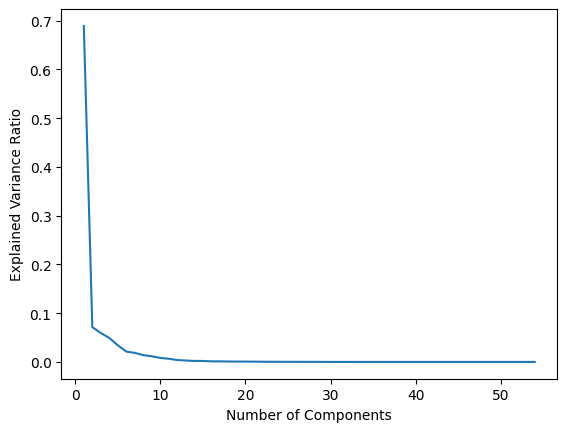

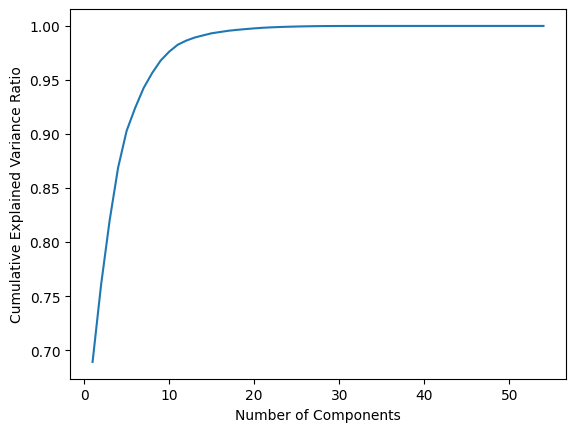

In [26]:
utils.plot_pca(df.drop(excluded_cols, axis=1))

In [27]:
n_components = 10
df = utils.feature_aggregation_pca(df, n_components, excluded_cols)
utils.print_columns(df)

[ PC1, PC2, PC3, PC4, PC5, PC6, PC7, PC8, PC9, PC10, tmID_0, tmID_1, tmID_2, tmID_3, tmID_4, franchID_0, franchID_1, franchID_2, franchID_3, franchID_4, name_0, name_1, name_2, name_3, name_4, coachID_0, coachID_1, coachID_2, coachID_3, coachID_4, coachID_5, confID, year, firstRound, semis, finals, playoff ]


## Checking for Correlation

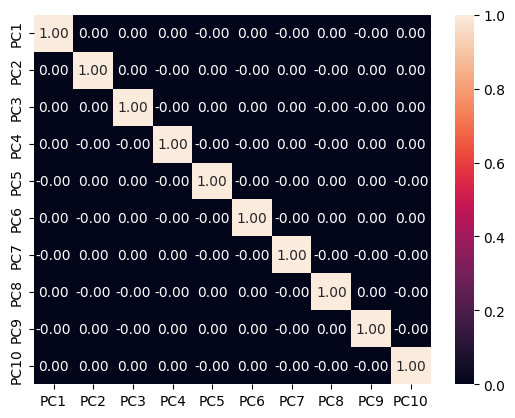

<Figure size 14400x14400 with 0 Axes>

In [28]:
utils.plot_correlation(df.drop(excluded_cols, axis=1))

## Checking for null values

In [29]:
print("Number of null values: ", df.isnull().sum().sum())

Number of null values:  0


# Saving the data

In [30]:
df.to_csv("../data/transformed.csv", index=False)